# This code shows how to generate a data set using pygme

For each galaxy simulated, a cube of imageSize x imageSize x imageDepth is generated

In [1]:
import numpy as np
import math
# pygme itself
import pygme
# the fitting for N 2Dimensional Gaussians
from pygme.fitting import fitn2dgauss
from pygme.fitting import fitGaussHermite
import matplotlib.pyplot as plt
# the warnings above can be ignored. This comes from an import of lmfit, which is by default not installed.
# Note: all the pygme code has been made compatible with python3 using *2to3*. A new version of pygme is being developed which is more pythonic and more robust, but this is written entirely from scratch.

# We import the module
from pygme.astroprofiles import sersic
# Import the module
from pygme.paramMGE import create_mge
# Importing the fitting routine
from pygme.fitting.fitn1dgauss import multi_1dgauss_mpfit

## Import the histogram functionalities
from pygme.pyhist import comp_losvd

         Available from pygme.fitting


In [2]:

def funSamplingOriginal(R):
    """
        initial function used to sample the galaxy radius [pc]
        
    Parameters
    ----------
        R : radius[pc]
    
    Returns
    ------
    : numpy vector

    """
    return np.logspace(0., 4., 1001)

def funSampling(R):
    """
        new function used to sample the galaxy radius [pc]
    
    Parameters
    ----------
        R : radius[pc]
        
    Returns
    ------
    : numpy vector

    """
    return np.logspace(np.log10(R/100.), np.log10(R*10), 1001)
import numpy

In [3]:

    

def GenImagesRe(par):
    """
    Function generating the dataset from parameter sets
    
    Parameters
    ----------
    par: class with the parameters of the simulation
        
    Returns
    ------
    :    dataset as vector of matrices, vector of data cubes and vector of target parameters,  
    X, X3Dxr ,Y

    """  
    # data set index
    i = 0  
    
    # vector of velocity values in [-maxV, maxV]
    rlos = np.linspace(-par.maxV, par.maxV, par.nv)
    
    # calculate the dimensions of the extracted datacube (not using all data at this step)
    nlow = int(par.nXY/2 - par.imageSize/2)
    nhigh =int(par.nXY/2 + par.imageSize/2)
    nvlow = int((par.nv-1)/2 - par.imageDepth/2)
    nvhigh =int((par.nv-1)/2 + par.imageDepth/2 + 1)     
    
    # calculation of the size of the data set based on the set of parameter vectors
    lenset = len(par.gamma)*len(par.factor_luminosity)*len(par.axis_ratio)* len(par.alpha)*len(par.FBEps)*len(par.Re)
    
    # data structure containing the LOSVD paarameters (X) or the data cubes (X3Dxr)
    X = np.zeros((lenset, par.imageSize, par.imageSize)) 
    X3Dxr = np.zeros((lenset, par.imageSize, par.imageSize, par.nv)) 
    
    # set of parameters vectors to infer with DL (mblack)(factor_luminosity)(axis_ratio)(alpha)(FBEps)           
    Y = np.zeros((lenset, 9)) 
    
    # parameter relating Sersic parameter beta to ellipticity: beta = epsilon * FBEps
    BEps = par.FBEps[0] #initialization for each call
    
    
    # L2ML = 8.04615596542e9/100. #[Msol]    

    # loop on Sersic effective Radii
    for Reff in par.Re:
        
        # We first set up a sampling in radius (in parsec)
        # From let's say 1 pc to about 10000 pc
        #rsamp = np.logspace(0.,4.,1001) INITIALLY
        #rsamp = np.logspace(0, np.log10(Reff), 1001)
        #rsamp = np.logspace(np.log10(Reff/100.), np.log10(Reff*10), 1001)
        rsamp = par.fun(Reff)

        # now we get the profile itself - for Re = 1500pc, rsamp goes to 6000pc, hence 4 Re
        myprofile = sersic.SersicProfile(n=2, Ie=1.0, Re=Reff, rsamp=rsamp)

        # Defining the maximum number of gaussians to approximate the profile.
        nGauss = 14

        # Fit Gaussians to the profile
        bestparSersic, mpfit_output, fitSersic = multi_1dgauss_mpfit(myprofile.r, myprofile.rhop, ngauss=nGauss)
        
        # check on Gaussians?

        # Number of Gaussian for the N body
        ngaussModel = bestparSersic.shape[0]
       
        # radius inside which LOSVD is calculated [pc]        
        # take scaleR = effRadius *1.6 
        # was 2500pc/11 pix -> now 0.43 kpc/pix = 43.43kpc
        scaleR = par.scaleR #new should be #432.14*50  #43430/2. *2 /101= 432 pc/pix was #2*43430pc/2/101 = 430pc/pix    
    
        # loop on axis ratio
        for ax in par.axis_ratio:
            
          # loop on factor_luminosity
          for fct in par.factor_luminosity:
                
            # set black hole mass depending on approximated galaxy total mass to limit MBH range
            mblack = par.gamma * par.delta * (Reff**2) * fct #fct needs to follow the increase of Ms
            
            #loop on Black hole mass
            for m in mblack:  
                
              print("m :"+str(m)+" gamma:"+str(par.gamma))
                
              # We add some zeros (0) to add 1- the axis ratio 2- position angle 
              parModel = np.hstack((bestparSersic, np.ones((ngaussModel,2))))

              kpc3_to_pc3 = 1.e9
              kpc_to_pc = 1.e3
                
              # First column is the amplitude. We can change it with some factor to make the total mass that we want
              # factor_luminosity is set arbitrarily here so that later we get something reasonable for the luminosity
              # of the galaxy. Hence you can change that in any way you wish (if you want larger or smaller galaxies)       
              parModel[:,0] *= fct
              # Transforming the sigmas (second column) into arcsec, as we did set up the radii in parsec initially
              parModel[:,1] /= par.pc_per_arcsec#48.481368110 [pc_per_arcsec]
              # Let's set the axis ratio - if b/a= 0.8 (ellipticity is 1-b/a = 0.2)
              parModel[:,2] = ax

              # The programme creates an ascii file "Sersic_firstmodel_try_*.mge" with the parameters of the projected and deprojected Gaussians
              filen = "Sersic_firstmodel_try_"+str(i)
              create_mge(outfilename=filen, Gauss2D=parModel, NGauss=(ngaussModel,0,0),overwrite=True,Distance=par.dist, NGroup=1, NDynGroup=1, NPartGroup=(par.nstars,0,0), NRealisedPartGroup=(par.nstars,0,0), MBH=mblack)
              print("mge created")
              myMGE = pygme.MGE(filen, saveMGE= "./", FacBetaEps=BEps) 
              print("BEps"+str(BEps))
              myMGE.betaeps = np.ones(myMGE._findGauss3D, dtype=np.int)
              print("myMGE.betaeps:"+str(myMGE.betaeps))
              # reinitilises
              #myMGE._init_BetaEps()               
              #print("myMGE.betaeps reinit:"+str(myMGE.betaeps))    
            
              print("Re:"+str(Reff))
              print("kRZ"+str(myMGE.kRZ))
              print("kRTheta"+str(myMGE.kRTheta) )
              
              # total Mass (in Msun)
              print("TMGEMass/1.e9:"+str(myMGE.TMGEMass / 1.e9))
              print("Mbh/1.e9 :"+str(myMGE.Mbh / 1.e9))
              ga = myMGE.Mbh/myMGE.TMGEMass
              print("Mbh/TMGEMass:"+str(myMGE.Mbh/myMGE.TMGEMass))
              
              # Making the N-body realisation   
              # This is the truncation radius in [pc] (beyond = no particles)
              maxR = Reff*10000./1500.
              print("maxR:"+str(maxR))
              myMGE.realise_Nbody(mcut=maxR, TruncationMethod="Ellipsoid") 

            
              #loop on rotation angle (data augmentation)
              
              for alp in par.alpha:
                
                 print("alpha:"+str(alp))
                 
                 # rotation around y axis (assume x along LOS) -> make sense only if calc LOSVD for (y,z, Vy) 
                 # Vxr: components along LOS of V (Vx and Vz) after rotation of the system around x or y
                 #Vxr =  myMGE.Vx[0:-1]*np.cos(alp) + myMGE.Vz[0:-1]*np.sin(alp) 
                 Vyr =  myMGE.Vy[0:-1]*np.cos(alp) + myMGE.Vz[0:-1]*np.sin(alp)
                 # zr: position along LOS perp  (old z) of star after rotation of the system around x or y
                 zr = myMGE.z[0:-1]*np.cos(alp)  

                 ## Compute the LOSVDs
                 print("losvd")
                 #losxr =  comp_losvd(myMGE.y[0:-1], zr, Vxr, weights=myMGE.BodMass[0:-1], limXY=[-scaleR, scaleR, -scaleR, scaleR],nXY=nXY, limV=[-maxV,maxV], nV=nv)
                 losxr =  comp_losvd(myMGE.x[0:-1], zr, Vyr, weights=myMGE.BodMass[0:-1], limXY=[-scaleR, scaleR, -scaleR, scaleR],nXY=par.nXY, limV=[-par.maxV, par.maxV], nV=par.nv)

                 #for ref losxr =  comp_losvd(myMGE.x, myMGE.z, myMGE.Vy, weights=myMGE.BodMass, limXY=[-scaleR, scaleR, -scaleR, scaleR],nXY=nXY, limV=[-maxV,maxV], nV=nv)
                 
                 X3Dxr[i] = losxr.losvd[nlow:nhigh,nlow:nhigh,nvlow:nvhigh]                
             
                 # compute Gauss Hermite polynomials and store one parameter
                 for p in range(0,par.imageSize):
                      for q in range(0,par.imageSize):
                          try:
                              bestR, result, GHbest = fitGaussHermite.fitGH_mpfit(rlos, losx.losvd[nlow+p,nlow+q], degGH=2,verbose=False)
                          except:
                              X[i,p,q]=0.
                          else:
                              X[i,p,q]=bestR[2]
                          
                          
                 #store parameters # mblack,   factor_luminosity, axis_ratio, FBEps, view_angle, dist, (size), gamma (superflous)
                 Y[i] = np.array([Reff, m, fct , ax, BEps, alp, par.dist, ga, myMGE.TMGEMass  ])
		 
                 print("Y["+str(i)+"]="+str(Y[i]))
                 i=i+1
    
            
    return X, X3Dxr ,Y

In [5]:
# test 1: compare old settings with example

class params1():   
    def __init__(self):
        """    
        Function generating the dataset from parameter sets
    
        Parameters
        ----------
        
        """

        
        # HARD PARAMETERS (set for one data set)
        self.nstars = 10000 #number of stars in each galaxy; 1M would be ideal

        ## Number of points in the Velocity direction
        self.nv = 101

        self.maxV = 1000. #in [km/s], maximum velocity for the LOSVDs
    
        ## Number of point in the X and Y direction (the total number will be nXY * nXY)
        ## You can also specify a tupple for different numbers in X and Y    
        self.nXY = 101    
        
        #number of values along axes perpendicular to LOS
        self.imageSize= 20 #
       
        #number of values along velocity axis
        self.imageDepth= self.nv - 1

        # constant to dimensionate MBH ; Mgal ~ delta * Re**2 (@luminosity =100)
        self.delta = 896.7 

        # SOFT PARAMETERS (explore the parameter space in each data set)    
        #  Effective radius of Sersic profile in [pc]
        self.Re = np.array([ 1500.])
   
        # distance of the galaxy in [Mpc]
        self.dist = 10 #Mpc
        
        # pc/arcsec = Distance[Mpc] * Pi / 0.648                      
        self.pc_per_arcsec = self.dist * math.pi / 0.648 

        # Let's add some axis ratio - here let's decide it is b/a= 0.55 (ellipticity is 1-b/a = 0.45)
        # axis_ratio : b/a where b is the small axis along z and a in the plan xy perpendicular to z (z = symmetry axis)
        self.axis_ratio = np.array([0.8])
   
        # parameter relating Sersic parameter beta to ellipticity beta = epsilon * FBEps
        self.FBEps = np.array([0.6]) 

        # angle of rotation of the system to perform data augmentation without increasing CPU time significantly
        self.alpha = np.array([0.])

        # radius inside which LOSVD is calculated [pc]
        #scaleR = 21607.0   #432.14*50 ??   
        self.scaleR = 5000.0
        # here we do 1 check: use only a single vector of parameters 
        # [0-100] Galaxy mass = factor_luminosity * galaxy luminosity
        self.factor_luminosity = np.array([100.])
     
        # task is just a convenient index to distribute parameters to each process running on a specific node
        task = 0 #only 1 process in use here
     
        # factor relating the black hole mass and the total galaxy mass
        self.gamma = np.array([0.,0.2])[int(task):int(task)+1] #1 value here
   
        # This is the truncation radius in [pc] (beyond = no particles)
       
        
        # function used to sample the galxy radius [pc]
        self.fun = funSamplingOriginal
        

        
        
        
        

In [6]:


#check original call
#Reproducible results:
np.random.seed(123)

#test 1:
p1 = params1()
Xc, X3Dxc ,Yc = GenImagesRe(p1)





/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/astroprofiles/data/Abel_param.dat
------ Starting the minimisation -------
Chi2 =  0.10241031061549845
Chi2 =  0.014457705522483294
Chi2 =  0.013960011416424214
Chi2 =  0.013116020286641309
Chi2 =  0.011879688080248935
Chi2 =  0.01035274546013426
Chi2 =  0.008375630255044994
Chi2 =  0.005506317785426071
Chi2 =  0.002525236070531542
Chi2 =  0.0024249413173733506
Chi2 =  0.002273463318819753
Chi2 =  0.002089673739938614
Chi2 =  0.0018773803710555375
Chi2 =  0.0015509288592703467
Chi2 =  0.0010905577109238723
Chi2 =  0.0010779645718402913
Chi2 =  0.0010560260300138346
Chi2 =  0.0010179698655027427
Chi2 =  0.0009484926774048887
Chi2 =  0.0008332682654171192
Chi2 =  0.0006749804945130777
Chi2 =  0.0006712691346174558
Chi2 =  0.0006646284971902093
Chi2 =  0.0006520775176415595
Chi2 =  0.0006294205193113726
Chi2 =  0.0005917135398438146
Chi2 =  0.0005365074454162337
Chi2 =  0.0005336544853121585
Chi2 =  0.0005283126996912723
Chi2 =  0.

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


FIT:      Imax       Sig   
GAUSS 01: 1.795e+00     1.122
GAUSS 02: 2.497e+00     2.949
GAUSS 03: 3.295e+00     7.123
GAUSS 04: 4.084e+00    16.048
GAUSS 05: 4.708e+00    34.020
GAUSS 06: 4.980e+00    68.277
GAUSS 07: 4.757e+00   130.289
GAUSS 08: 4.027e+00   237.185
GAUSS 09: 2.960e+00   413.118
GAUSS 10: 1.851e+00   690.559
GAUSS 11: 9.685e-01  1113.156
GAUSS 12: 4.178e-01  1751.680
GAUSS 13: 1.385e-01  2786.813
GAUSS 14: 2.253e-02  4885.631
Chi2:  0.00018632023527051853  Reduced Chi2:  1.861341011693492e-07
m :0.0 gamma:[0.]
WARNING with status 1 while Problem with Euler angles, will set the default = 0, 90, 0 = edge-on
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.09461976e+03           0.02314   0.80000   0.80000
3D-G  2    1.63757231e+03           0.06082   0.80000   0.80000
3D-G  3    8.94777097e+02           0.14692   0.80000   0.80000
3D-G  4    4.92

In [7]:
print("dist:{}".format(p1.dist))
print("pc_per_arcsec_10Mpc: {} vs {}".format(p1.dist * math.pi / 0.648, 48.481368110))
print("scaleR:{} vs {}".format(p1.scaleR, 5000.0))

dist:10
pc_per_arcsec_10Mpc: 48.481368110953596 vs 48.48136811
scaleR:5000.0 vs 5000.0


XRef.shape(20, 20, 101)
X3Dxc.shape(20, 20, 101)
Image difference ratio:0.0


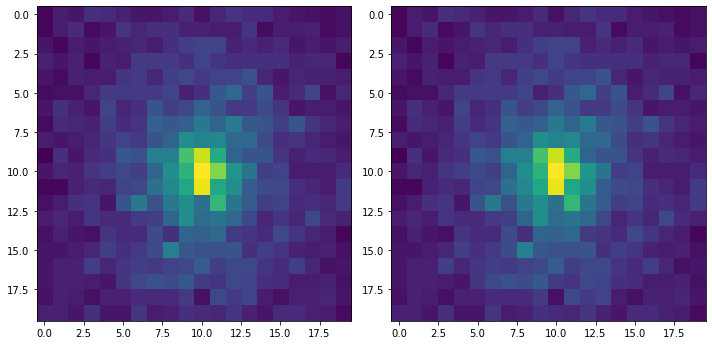

In [8]:
nameGal = "./pygme_check_data.npy"
XRef = np.load(nameGal, allow_pickle=True)
Xcalc = X3Dxc[0]
print("XRef.shape"+str(XRef.shape))
print("X3Dxc.shape"+str(X3Dxc[0].shape))
print("Image difference ratio:"+str((np.max(XRef)-np.max(Xcalc))/np.max(XRef)))
%matplotlib inline
fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.imshow((X3Dxc[0].sum(axis=2)))
ax2 = fig.add_subplot(122)
ax2.imshow((XRef.sum(axis=2)))
plt.tight_layout()

# Test effect of distance and varying pixel size

In [9]:
# test 1: compare old settings with example

class params1_far():   
    def __init__(self):
        """    
        Function generating the dataset from parameter sets
    
        Parameters
        ----------
        
        """

        
        # HARD PARAMETERS (set for one data set)
        self.nstars = 10000 #number of stars in each galaxy; 1M would be ideal

        ## Number of points in the Velocity direction
        self.nv = 101

        self.maxV = 1000. #in [km/s], maximum velocity for the LOSVDs
    
        ## Number of point in the X and Y direction (the total number will be nXY * nXY)
        ## You can also specify a tupple for different numbers in X and Y    
        self.nXY = 101    
        
        #number of values along axes perpendicular to LOS
        self.imageSize= 20 # 
       
        #number of values along velocity axis
        self.imageDepth= self.nv - 1

        # constant to dimensionate MBH ; Mgal ~ delta * Re**2 (@luminosity =100)
        self.delta = 896.7 

        # SOFT PARAMETERS (explore the parameter space in each data set)    
        #  Effective radius of Sersic profile in [pc]
        self.Re = np.array([ 1500.])
   
        # distance of the galaxy in [Mpc]
        self.dist = 20 #was 10 #Mpc
        
        # pc/arcsec = Distance[Mpc] * Pi / 0.648                      
        self.pc_per_arcsec = self.dist * math.pi / 0.648 

        # Let's add some axis ratio - here let's decide it is b/a= 0.55 (ellipticity is 1-b/a = 0.45)
        # axis_ratio : b/a where b is the small axis along z and a in the plan xy perpendicular to z (z = symmetry axis)
        self.axis_ratio = np.array([0.8])
   
        # parameter relating Sersic parameter beta to ellipticity beta = epsilon * FBEps
        self.FBEps = np.array([0.6]) 

        # angle of rotation of the system to perform data augmentation without increasing CPU time significantly
        self.alpha = np.array([0.])

        # radius inside which LOSVD is calculated [pc]
        #scaleR = 21607.0   #432.14*50 ??   
        self.scaleR = 5000.0
        # here we do 1 check: use only a single vector of parameters 
        # [0-100] Galaxy mass = factor_luminosity * galaxy luminosity
        self.factor_luminosity = np.array([100.])
     
        # task is just a convenient index to distribute parameters to each process running on a specific node
        task = 0 #only 1 process in use here
     
        # factor relating the black hole mass and the total galaxy mass
        self.gamma = np.array([0.,0.2])[int(task):int(task)+1] #1 value here
   
        # This is the truncation radius in [pc] (beyond = no particles)
       
        
        # function used to sample the galxy radius [pc]
        self.fun = funSamplingOriginal
        

        
        
        
        

In [10]:


#check original call
#Reproducible results:
np.random.seed(123) #same as before

#test 1:
p1_far = params1_far()
Xc, X3Dxc ,Yc = GenImagesRe(p1_far)





/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/astroprofiles/data/Abel_param.dat
------ Starting the minimisation -------
Chi2 =  0.10241031061549845
Chi2 =  0.014457705522483294
Chi2 =  0.013960011416424214
Chi2 =  0.013116020286641309
Chi2 =  0.011879688080248935
Chi2 =  0.01035274546013426
Chi2 =  0.008375630255044994
Chi2 =  0.005506317785426071
Chi2 =  0.002525236070531542
Chi2 =  0.0024249413173733506
Chi2 =  0.002273463318819753
Chi2 =  0.002089673739938614
Chi2 =  0.0018773803710555375
Chi2 =  0.0015509288592703467
Chi2 =  0.0010905577109238723
Chi2 =  0.0010779645718402913
Chi2 =  0.0010560260300138346
Chi2 =  0.0010179698655027427
Chi2 =  0.0009484926774048887
Chi2 =  0.0008332682654171192
Chi2 =  0.0006749804945130777
Chi2 =  0.0006712691346174558
Chi2 =  0.0006646284971902093
Chi2 =  0.0006520775176415595
Chi2 =  0.0006294205193113726
Chi2 =  0.0005917135398438146
Chi2 =  0.0005365074454162337
Chi2 =  0.0005336544853121585
Chi2 =  0.0005283126996912723
Chi2 =  0.

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


FIT:      Imax       Sig   
GAUSS 01: 1.795e+00     1.122
GAUSS 02: 2.497e+00     2.949
GAUSS 03: 3.295e+00     7.123
GAUSS 04: 4.084e+00    16.048
GAUSS 05: 4.708e+00    34.020
GAUSS 06: 4.980e+00    68.277
GAUSS 07: 4.757e+00   130.289
GAUSS 08: 4.027e+00   237.185
GAUSS 09: 2.960e+00   413.118
GAUSS 10: 1.851e+00   690.559
GAUSS 11: 9.685e-01  1113.156
GAUSS 12: 4.178e-01  1751.680
GAUSS 13: 1.385e-01  2786.813
GAUSS 14: 2.253e-02  4885.631
Chi2:  0.00018632023527051853  Reduced Chi2:  1.861341011693492e-07
m :0.0 gamma:[0.]
WARNING with status 1 while Problem with Euler angles, will set the default = 0, 90, 0 = edge-on
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    6.18923951e+03           0.01157   0.80000   0.80000
3D-G  2    3.27514463e+03           0.03041   0.80000   0.80000
3D-G  3    1.78955419e+03           0.07346   0.80000   0.80000
3D-G  4    9.84

In [11]:
print("dist:{}".format(p1_far.dist))
print("pc_per_arcsec_10Mpc: {} vs {}".format(p1_far.dist * math.pi / 0.648, 48.481368110))
print("scaleR:{} vs {}".format(p1_far.scaleR, 5000.0))

dist:20
pc_per_arcsec_10Mpc: 96.96273622190719 vs 48.48136811
scaleR:5000.0 vs 5000.0


XRef.shape(20, 20, 101)
X3Dxc.shape(20, 20, 101)
Image difference ratio:2.9772882567115564e-07


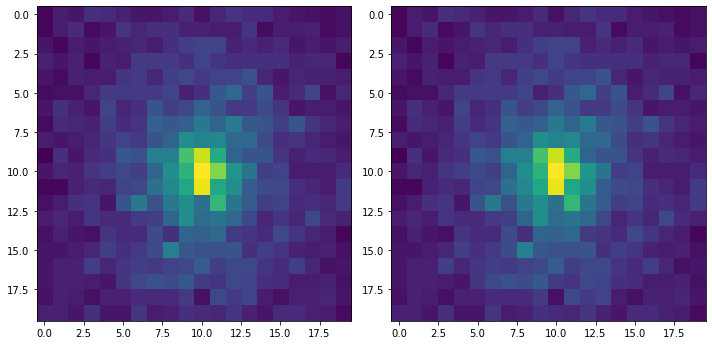

In [12]:
nameGal = "./pygme_check_data.npy"
XRef = np.load(nameGal, allow_pickle=True)
Xcalc = X3Dxc[0]
print("XRef.shape"+str(XRef.shape))
print("X3Dxc.shape"+str(X3Dxc[0].shape))
print("Image difference ratio:"+str((np.max(XRef)-np.max(Xcalc))/np.max(XRef)))
%matplotlib inline
fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.imshow((X3Dxc[0].sum(axis=2)))
ax2 = fig.add_subplot(122)
ax2.imshow((XRef.sum(axis=2)))
plt.tight_layout()

Image was adjusted with "pc_per_arcsec = par.dist * math.pi / 0.648 "

# Changing distance with same pixel size

In [13]:
# test 1: compare old settings with example

class params1_far2():   
    def __init__(self):
        """    
        Function generating the dataset from parameter sets
    
        Parameters
        ----------
        
        """

        
        # HARD PARAMETERS (set for one data set)
        self.nstars = 10000 #number of stars in each galaxy; 1M would be ideal

        ## Number of points in the Velocity direction
        self.nv = 101

        self.maxV = 1000. #in [km/s], maximum velocity for the LOSVDs
    
        ## Number of point in the X and Y direction (the total number will be nXY * nXY)
        ## You can also specify a tupple for different numbers in X and Y    
        self.nXY = 101    
        
        #number of values along axes perpendicular to LOS
        self.imageSize= 20 #
       
        #number of values along velocity axis
        self.imageDepth= self.nv - 1

        # constant to dimensionate MBH ; Mgal ~ delta * Re**2 (@luminosity =100)
        self.delta = 896.7 

        # SOFT PARAMETERS (explore the parameter space in each data set)    
        #  Effective radius of Sersic profile in [pc]
        self.Re = np.array([ 1500.])
   
        # distance of the galaxy in [Mpc]
        self.dist = 20 #was 10 #Mpc
        
        # pc/arcsec = Distance[Mpc] * Pi / 0.648                      
        self.pc_per_arcsec = 10. * math.pi / 0.648  #keep same pixel amgle as before @10Mpc

        # Let's add some axis ratio - here let's decide it is b/a= 0.55 (ellipticity is 1-b/a = 0.45)
        # axis_ratio : b/a where b is the small axis along z and a in the plan xy perpendicular to z (z = symmetry axis)
        self.axis_ratio = np.array([0.8])
   
        # parameter relating Sersic parameter beta to ellipticity beta = epsilon * FBEps
        self.FBEps = np.array([0.6]) 

        # angle of rotation of the system to perform data augmentation without increasing CPU time significantly
        self.alpha = np.array([0.])

        # radius inside which LOSVD is calculated [pc]
        #scaleR = 21607.0   #432.14*50 ??   
        self.scaleR = 5000.0
        # here we do 1 check: use only a single vector of parameters 
        # [0-100] Galaxy mass = factor_luminosity * galaxy luminosity
        self.factor_luminosity = np.array([100.])
     
        # task is just a convenient index to distribute parameters to each process running on a specific node
        task = 0 #only 1 process in use here
     
        # factor relating the black hole mass and the total galaxy mass
        self.gamma = np.array([0.,0.2])[int(task):int(task)+1] #1 value here
   
        # This is the truncation radius in [pc] (beyond = no particles)
       
        
        # function used to sample the galxy radius [pc]
        self.fun = funSamplingOriginal
        

        
        
        
        

In [14]:


#check original call
#Reproducible results:
np.random.seed(123) #same as before

#test 1:
p1_far2 = params1_far2()
Xc, X3Dxc ,Yc = GenImagesRe(p1_far2)





/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/astroprofiles/data/Abel_param.dat
------ Starting the minimisation -------
Chi2 =  0.10241031061549845
Chi2 =  0.014457705522483294
Chi2 =  0.013960011416424214
Chi2 =  0.013116020286641309
Chi2 =  0.011879688080248935
Chi2 =  0.01035274546013426
Chi2 =  0.008375630255044994
Chi2 =  0.005506317785426071
Chi2 =  0.002525236070531542
Chi2 =  0.0024249413173733506
Chi2 =  0.002273463318819753
Chi2 =  0.002089673739938614
Chi2 =  0.0018773803710555375
Chi2 =  0.0015509288592703467
Chi2 =  0.0010905577109238723
Chi2 =  0.0010779645718402913
Chi2 =  0.0010560260300138346
Chi2 =  0.0010179698655027427
Chi2 =  0.0009484926774048887
Chi2 =  0.0008332682654171192
Chi2 =  0.0006749804945130777
Chi2 =  0.0006712691346174558
Chi2 =  0.0006646284971902093
Chi2 =  0.0006520775176415595
Chi2 =  0.0006294205193113726
Chi2 =  0.0005917135398438146
Chi2 =  0.0005365074454162337
Chi2 =  0.0005336544853121585
Chi2 =  0.0005283126996912723
Chi2 =  0.

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


Chi2 =  0.00018632023528646508
Chi2 =  0.00018632023528113072
Chi2 =  0.00018632023527603985
FIT:      Imax       Sig   
GAUSS 01: 1.795e+00     1.122
GAUSS 02: 2.497e+00     2.949
GAUSS 03: 3.295e+00     7.123
GAUSS 04: 4.084e+00    16.048
GAUSS 05: 4.708e+00    34.020
GAUSS 06: 4.980e+00    68.277
GAUSS 07: 4.757e+00   130.289
GAUSS 08: 4.027e+00   237.185
GAUSS 09: 2.960e+00   413.118
GAUSS 10: 1.851e+00   690.559
GAUSS 11: 9.685e-01  1113.156
GAUSS 12: 4.178e-01  1751.680
GAUSS 13: 1.385e-01  2786.813
GAUSS 14: 2.253e-02  4885.631
Chi2:  0.00018632023527051853  Reduced Chi2:  1.861341011693492e-07
m :0.0 gamma:[0.]
WARNING with status 1 while Problem with Euler angles, will set the default = 0, 90, 0 = edge-on
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.09461976e+03           0.02314   0.80000   0.80000
3D-G  2    1.63757231e+03           0.06082   0.80

In [15]:
print("dist:{}".format(p1_far2.dist))
print("pc_per_arcsec_10Mpc: {} vs {}".format(p1_far2.dist * math.pi / 0.648, 48.481368110))
print("scaleR:{} vs {}".format(p1_far2.scaleR, 5000.0))

dist:20
pc_per_arcsec_10Mpc: 96.96273622190719 vs 48.48136811
scaleR:5000.0 vs 5000.0


XRef.shape(20, 20, 101)
X3Dxc.shape(20, 20, 101)
Image difference ratio:-0.7428362233127347


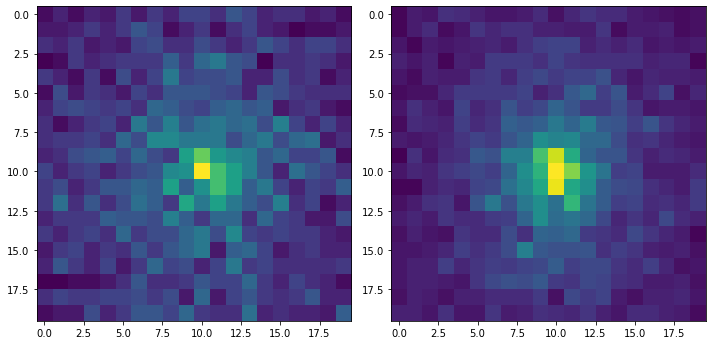

In [16]:
nameGal = "./pygme_check_data.npy"
XRef = np.load(nameGal, allow_pickle=True)
Xcalc = X3Dxc[0]
print("XRef.shape"+str(XRef.shape))
print("X3Dxc.shape"+str(X3Dxc[0].shape))
print("Image difference ratio:"+str((np.max(XRef)-np.max(Xcalc))/np.max(XRef)))
%matplotlib inline
fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.imshow((X3Dxc[0].sum(axis=2)))
ax2 = fig.add_subplot(122)
ax2.imshow((XRef.sum(axis=2)))
plt.tight_layout()

reduction by factor 2 this time

# At large distance with same pixel size

In [17]:
# test 1: compare old settings with example

class params1_far3():   
    def __init__(self):
        """    
        Function generating the dataset from parameter sets
    
        Parameters
        ----------
        
        """

        
        # HARD PARAMETERS (set for one data set)
        self.nstars = 10000 #number of stars in each galaxy; 1M would be ideal

        ## Number of points in the Velocity direction
        self.nv = 101

        self.maxV = 1000. #in [km/s], maximum velocity for the LOSVDs
    
        ## Number of point in the X and Y direction (the total number will be nXY * nXY)
        ## You can also specify a tupple for different numbers in X and Y    
        self.nXY = 101    
        
        #number of values along axes perpendicular to LOS
        self.imageSize= 20 # 
       
        #number of values along velocity axis
        self.imageDepth= self.nv - 1

        # constant to dimensionate MBH ; Mgal ~ delta * Re**2 (@luminosity =100)
        self.delta = 896.7 

        # SOFT PARAMETERS (explore the parameter space in each data set)    
        #  Effective radius of Sersic profile in [pc]
        self.Re = np.array([ 1500.])
   
        # distance of the galaxy in [Mpc]
        self.dist = 222.9 #was 10 #Mpc
        
        # pc/arcsec = Distance[Mpc] * Pi / 0.648                      
        self.pc_per_arcsec = 10. * math.pi / 0.648  #keep same pixel amgle as before @10Mpc

        # Let's add some axis ratio - here let's decide it is b/a= 0.55 (ellipticity is 1-b/a = 0.45)
        # axis_ratio : b/a where b is the small axis along z and a in the plan xy perpendicular to z (z = symmetry axis)
        self.axis_ratio = np.array([0.8])
   
        # parameter relating Sersic parameter beta to ellipticity beta = epsilon * FBEps
        self.FBEps = np.array([0.6]) 

        # angle of rotation of the system to perform data augmentation without increasing CPU time significantly
        self.alpha = np.array([0.])

        # radius inside which LOSVD is calculated [pc]
        #scaleR = 21607.0   #432.14*50 ??   
        self.scaleR = 5000.0
        # here we do 1 check: use only a single vector of parameters 
        # [0-100] Galaxy mass = factor_luminosity * galaxy luminosity
        self.factor_luminosity = np.array([100.])
     
        # task is just a convenient index to distribute parameters to each process running on a specific node
        task = 0 #only 1 process in use here
     
        # factor relating the black hole mass and the total galaxy mass
        self.gamma = np.array([0.,0.2])[int(task):int(task)+1] #1 value here
   
        # This is the truncation radius in [pc] (beyond = no particles)
       
        
        # function used to sample the galxy radius [pc]
        self.fun = funSamplingOriginal
        

        
        
        
        

In [18]:


#check original call
#Reproducible results:
np.random.seed(123) #same as before

#test 4:
p1_far3 = params1_far3()
Xc, X3Dxc ,Yc = GenImagesRe(p1_far3)





/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/astroprofiles/data/Abel_param.dat
------ Starting the minimisation -------
Chi2 =  0.10241031061549845
Chi2 =  0.014457705522483294
Chi2 =  0.013960011416424214
Chi2 =  0.013116020286641309
Chi2 =  0.011879688080248935
Chi2 =  0.01035274546013426
Chi2 =  0.008375630255044994
Chi2 =  0.005506317785426071
Chi2 =  0.002525236070531542
Chi2 =  0.0024249413173733506
Chi2 =  0.002273463318819753
Chi2 =  0.002089673739938614
Chi2 =  0.0018773803710555375
Chi2 =  0.0015509288592703467
Chi2 =  0.0010905577109238723
Chi2 =  0.0010779645718402913
Chi2 =  0.0010560260300138346
Chi2 =  0.0010179698655027427
Chi2 =  0.0009484926774048887
Chi2 =  0.0008332682654171192
Chi2 =  0.0006749804945130777
Chi2 =  0.0006712691346174558
Chi2 =  0.0006646284971902093
Chi2 =  0.0006520775176415595
Chi2 =  0.0006294205193113726
Chi2 =  0.0005917135398438146
Chi2 =  0.0005365074454162337
Chi2 =  0.0005336544853121585
Chi2 =  0.0005283126996912723
Chi2 =  0.

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


Chi2 =  0.00018632023527603985
FIT:      Imax       Sig   
GAUSS 01: 1.795e+00     1.122
GAUSS 02: 2.497e+00     2.949
GAUSS 03: 3.295e+00     7.123
GAUSS 04: 4.084e+00    16.048
GAUSS 05: 4.708e+00    34.020
GAUSS 06: 4.980e+00    68.277
GAUSS 07: 4.757e+00   130.289
GAUSS 08: 4.027e+00   237.185
GAUSS 09: 2.960e+00   413.118
GAUSS 10: 1.851e+00   690.559
GAUSS 11: 9.685e-01  1113.156
GAUSS 12: 4.178e-01  1751.680
GAUSS 13: 1.385e-01  2786.813
GAUSS 14: 2.253e-02  4885.631
Chi2:  0.00018632023527051853  Reduced Chi2:  1.861341011693492e-07
m :0.0 gamma:[0.]
WARNING with status 1 while Problem with Euler angles, will set the default = 0, 90, 0 = edge-on
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.09461976e+03           0.02314   0.80000   0.80000
3D-G  2    1.63757231e+03           0.06082   0.80000   0.80000
3D-G  3    8.94777097e+02           0.14692   0.

In [19]:
print("dist:{}".format(p1_far3.dist))
print("pc_per_arcsec_10Mpc: {} vs {}".format(p1_far3.dist * math.pi / 0.648, 48.481368110))
print("scaleR:{} vs {}".format(p1_far3.scaleR, 5000.0))

dist:222.9
pc_per_arcsec_10Mpc: 1080.6496951931556 vs 48.48136811
scaleR:5000.0 vs 5000.0


XRef.shape(20, 20, 101)
X3Dxc.shape(20, 20, 101)
Image difference ratio:-5.874886757116264


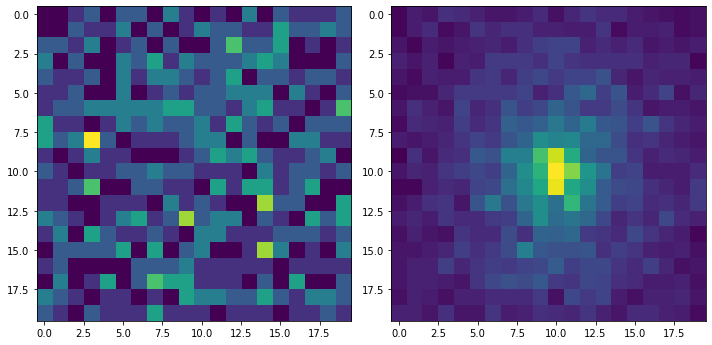

In [20]:
nameGal = "./pygme_check_data.npy"
XRef = np.load(nameGal, allow_pickle=True)
Xcalc = X3Dxc[0]
print("XRef.shape"+str(XRef.shape))
print("X3Dxc.shape"+str(X3Dxc[0].shape))
print("Image difference ratio:"+str((np.max(XRef)-np.max(Xcalc))/np.max(XRef)))
%matplotlib inline
fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.imshow((X3Dxc[0].sum(axis=2)))
ax2 = fig.add_subplot(122)
ax2.imshow((XRef.sum(axis=2)))
plt.tight_layout()

not visible anymore

# New parameters

In [21]:
# test 2: test run with new settings
class params2():   
    def __init__(self):

        # HARD PARAMETERS (set for one data set)
        self.nstars = 10000 #number of stars in each galaxy; 1M would be ideal
        ## Number of points in the Velocity direction
        self.nv = 29 #was 101 initially : Large binning !!!

        self.maxV = 1036.0 #in [km/s], maximum velocity for the LOSVDs
    
        ## Number of point in the X and Y direction (the total number will be nXY * nXY)
        ## You can also specify a tupple for different numbers in X and Y    
        self.nXY = 100 #was nXY= 101    

        self.imageSize= 20 # with 4x larger binning could take 4xRe as galaxy size
    
        self.imageDepth= self.nv -1

        # constant to dimensionate MBH ; Mgal ~ delta * Re**2 (@luminosity =100)
        self.delta = 896.7 

        # SOFT PARAMETERS (explore the parameter space in each data set)    
        #  Effective radius of Sersic profile in [pc]
        #Re = np.array([200])   # 0,2kpc to 20kpc 9too small)
        self.Re = np.array([ 1500.])
   
        # distance of the galaxy in [Mpc]
        self.dist = 222.9 #Mpc
        
        # pc/arcsec = Distance[Mpc] * Pi / 0.648                      
        self.pc_per_arcsec = self.dist * math.pi / 0.648 

        # Let's add some axis ratio - here let's decide it is b/a= 0.55 (ellipticity is222.9 1-b/a = 0.45)
        self.axis_ratio = np.array([0.55])

        # parameter relating Sersic parameter beta to ellipticity beta = epsilon * FBEps
        self.FBEps = np.array([0.6]) 

        # angle of rotation of the system to perform data augmentation without increasing CPU time significantly
        self.alpha = np.array([0.])

        # radius inside which LOSVD is calculated [pc]
        self.scaleR = 21607.0   #being 432.14*50 in real test image set 4x Binning vs params 1
   
        # here we do 1 check: use only a single vector of parameters 
        # [0-100] Galaxy mass = factor_luminosity * galaxy luminosity
        self.factor_luminosity = np.array([100.])
     
        # task is just a convenient index to distribute parameters to each process running on a specific node
        task = 0 #only 1 process in use here
     
        # factor relating the black hole mass and the total galaxy mass
        self.gamma = np.array([0.,0.2])[int(task):int(task)+1]
   
        # This is the truncation radius in [pc] (beyond = no particles)
        #maxR = Re*1.3 ???
        
        # radius sampling function
        self.fun = funSamplingOriginal
        

        
        
        

#check original call
#Reproducible results:
np.random.seed(123) #same as before

#test 5:
p2 = params2()
Xc, X3Dxc ,Yc = GenImagesRe(p2)


In [23]:
print("dist:{}".format(p2.dist))
print("pc_per_arcsec_10Mpc: {} vs {}".format(p2.dist * math.pi / 0.648, 48.481368110))
print("scaleR:{} vs {}".format(p2.scaleR, 5000.0))

dist:222.9
pc_per_arcsec_10Mpc: 1080.6496951931556 vs 48.48136811
scaleR:21607.0 vs 5000.0


XRef.shape(20, 20, 101)
X3Dxc.shape(20, 20, 29)
-15.920131924191942


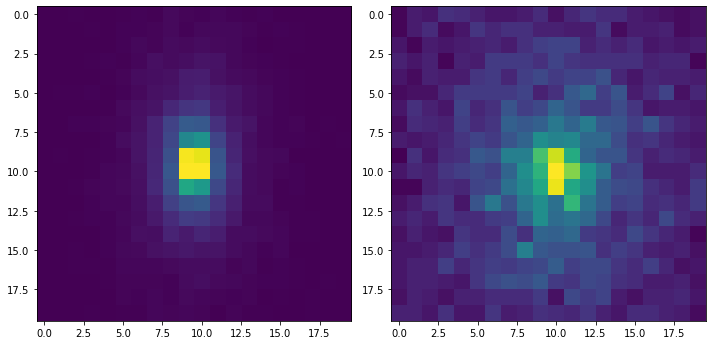

In [24]:
nameGal = "./pygme_check_data.npy"
XRef = np.load(nameGal, allow_pickle=True)
Xcalc = X3Dxc[0]
print("XRef.shape"+str(XRef.shape))
print("X3Dxc.shape"+str(X3Dxc[0].shape))
print((np.max(XRef)-np.max(Xcalc))/np.max(XRef))

fig = plt.figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.imshow((X3Dxc[0].sum(axis=2)))
ax2 = fig.add_subplot(122)
ax2.imshow((XRef.sum(axis=2)))
plt.tight_layout()

(xRef-4*4*xRef)/xRef =-15 : order of magnitude is ok